In [48]:
import requests
import json
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from os import listdir
import plotly.express as px
import secret
import re
import numpy as np

### Pulling down from new API

In [6]:
makes = [
    "acura",
    # "buick",
    # "cadillac",
    # "chevrolet",
    # "chrysler",
    # "gmc",
    # "ford",
    # "honda",
    # "infiniti",
    # "jeep",
    # "kia",
    # "mitsubishi",
    # "nissan",
    # "porsche",
    # "ram",
    # "subaru",
    # "toyota",
    # "volkswagen",
    # "volvo",
    # "alfa_romeo",
    # "rolls_royce",
    # "mini",
    # "fiat",
    # "aston_martin",
    # "maserati",
    # "bmw",
    # "mercedes_benz"
]


'''
Pull down the listings from the date provided from one week earlier
'''
def pull_down_weekly_listings(date) -> pd.DataFrame:
    
    url = secret.API_URL
    payload = ""
    headers = {"x-api-key": secret.API_KEY}
    
    df = pd.DataFrame()
    results = []
    
    
    for i in range(7):
        
        day = (date - timedelta(days=i)).date().isoformat()
        
        for make in makes:
    
            querystring = {"make":make,"date":day}


            response = requests.request("GET", url, data=payload, headers=headers, params=querystring)

            df_temp = pd.read_json(response.text)
            
            df = pd.concat([df, df_temp])
            
            

    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Year'].astype(str)
    
    return df
    

df = pull_down_weekly_listings(datetime.now())  
df.info()  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215 entries, 0 to 26
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Rating Count  215 non-null    int64         
 1   Date          215 non-null    datetime64[ns]
 2   Year          215 non-null    object        
 3   Mileage       215 non-null    int64         
 4   Price         215 non-null    int64         
 5   Dealer Name   215 non-null    object        
 6   ID            215 non-null    object        
 7   Make          215 non-null    object        
 8   Rating        215 non-null    float64       
 9   Date-Make     215 non-null    object        
 10  Name          215 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 20.2+ KB


##### Grab Last Week's Listings

In [7]:
df_last_week = pull_down_weekly_listings(datetime.now()- timedelta(days=7))  
df_last_week.info()  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192 entries, 0 to 33
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Rating Count  192 non-null    int64         
 1   Date          192 non-null    datetime64[ns]
 2   Year          192 non-null    object        
 3   Mileage       192 non-null    int64         
 4   Price         192 non-null    int64         
 5   Dealer Name   192 non-null    object        
 6   ID            192 non-null    object        
 7   Make          192 non-null    object        
 8   Rating        192 non-null    float64       
 9   Date-Make     192 non-null    object        
 10  Name          192 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 18.0+ KB


In [9]:
df['Name'].value_counts()

2020 Acura MDX 3.5L                         20
2020 Acura MDX 3.5L w/Technology Package    16
2019 Acura MDX 3.5L w/Technology Package    15
2020 Acura TLX FWD                          15
2021 Acura TLX Technology                   12
2019 Acura MDX 3.5L                         12
2019 Acura RDX Technology Package           11
2019 Acura RDX Base                         10
2020 Acura TLX V6 w/Technology Package      10
2020 Acura RDX Technology Package            8
2020 Acura RDX Advance Package               6
2021 Acura RDX w/Technology Package          6
2020 Acura TLX Technology                    5
2021 Acura RDX A-Spec                        5
2019 Acura RDX A-Spec                        4
2022 Acura MDX A-Spec                        4
2021 Acura RDX Technology Package            4
2022 Acura MDX w/Advance Package             4
2021 Acura TLX Tech                          3
2020 Acura RDX Base                          3
2019 Acura RDX                               3
2022 Acura MD

### Say a user chooses '2020 Acura MDX 3.5L'

In [ ]:
df_last_week[df_last_week['Name'] == '2020 Acura MDX 3.5L']['Mileage']

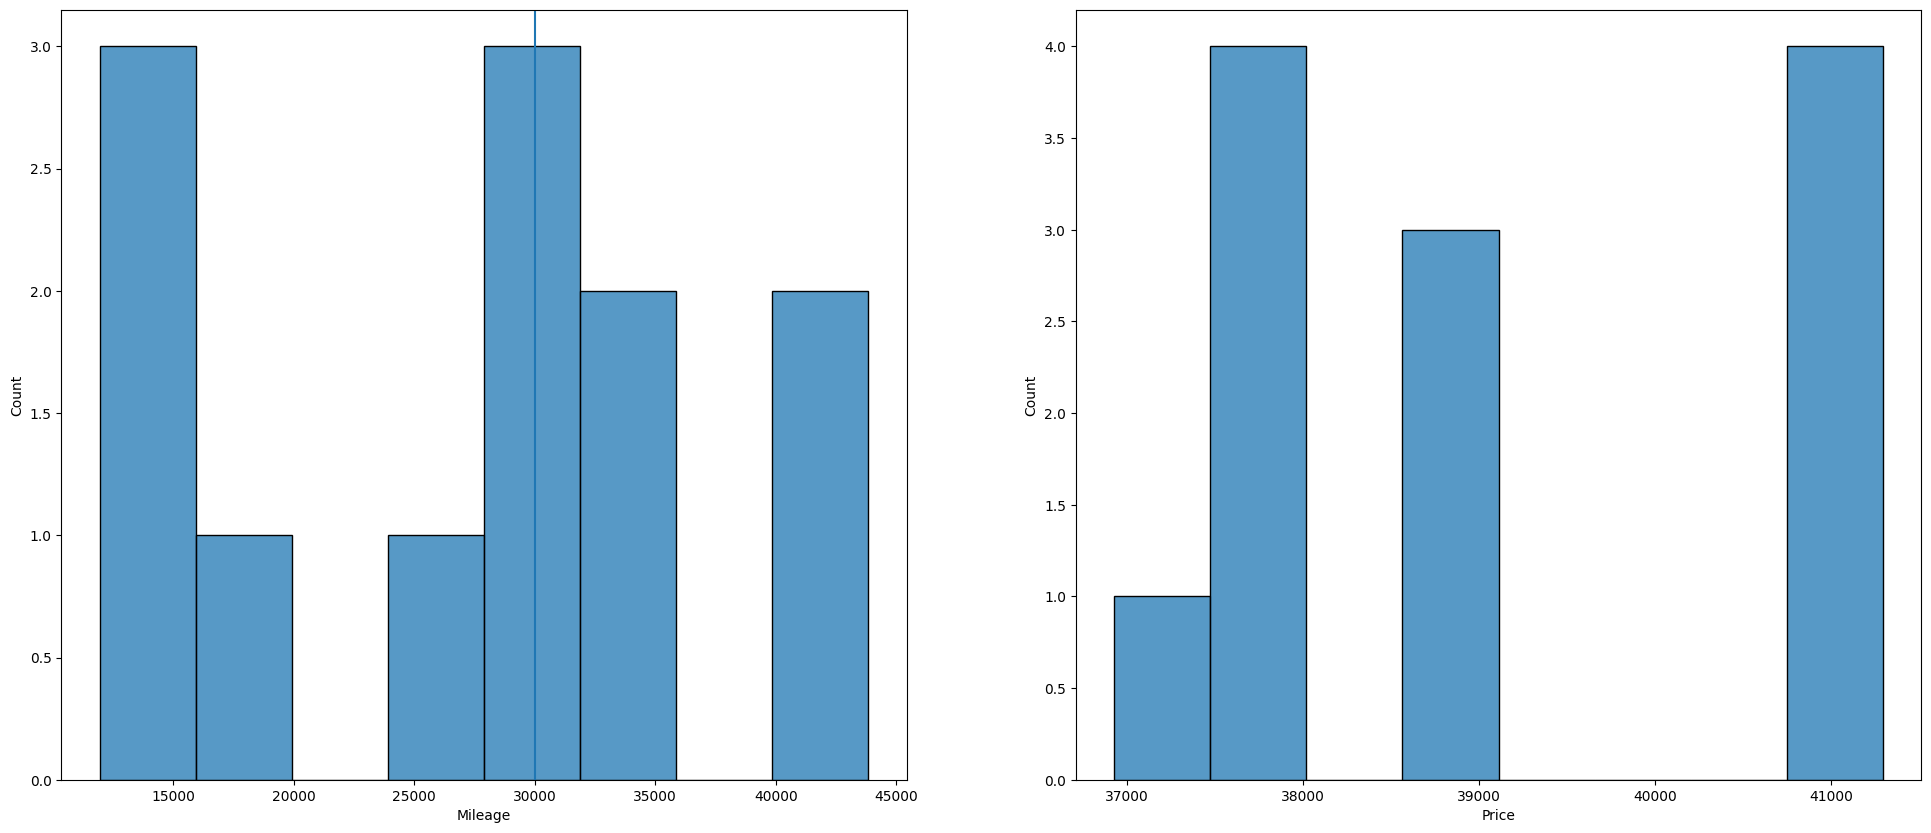

In [30]:
def hist_plot(make, df_hist):
    
    fig, ax = plt.subplots(1,2, figsize=(24,10))

    sns.histplot(
        data = df_hist[df_hist['Name'] == make]['Mileage'],
        bins = 8,
        ax = ax[0]

    )


    sns.histplot(
        data = df_hist[df_hist['Name'] == make]['Price'],
        bins = 8,
        ax = ax[1]
    )


hist_plot('2020 Acura MDX 3.5L', df_last_week)

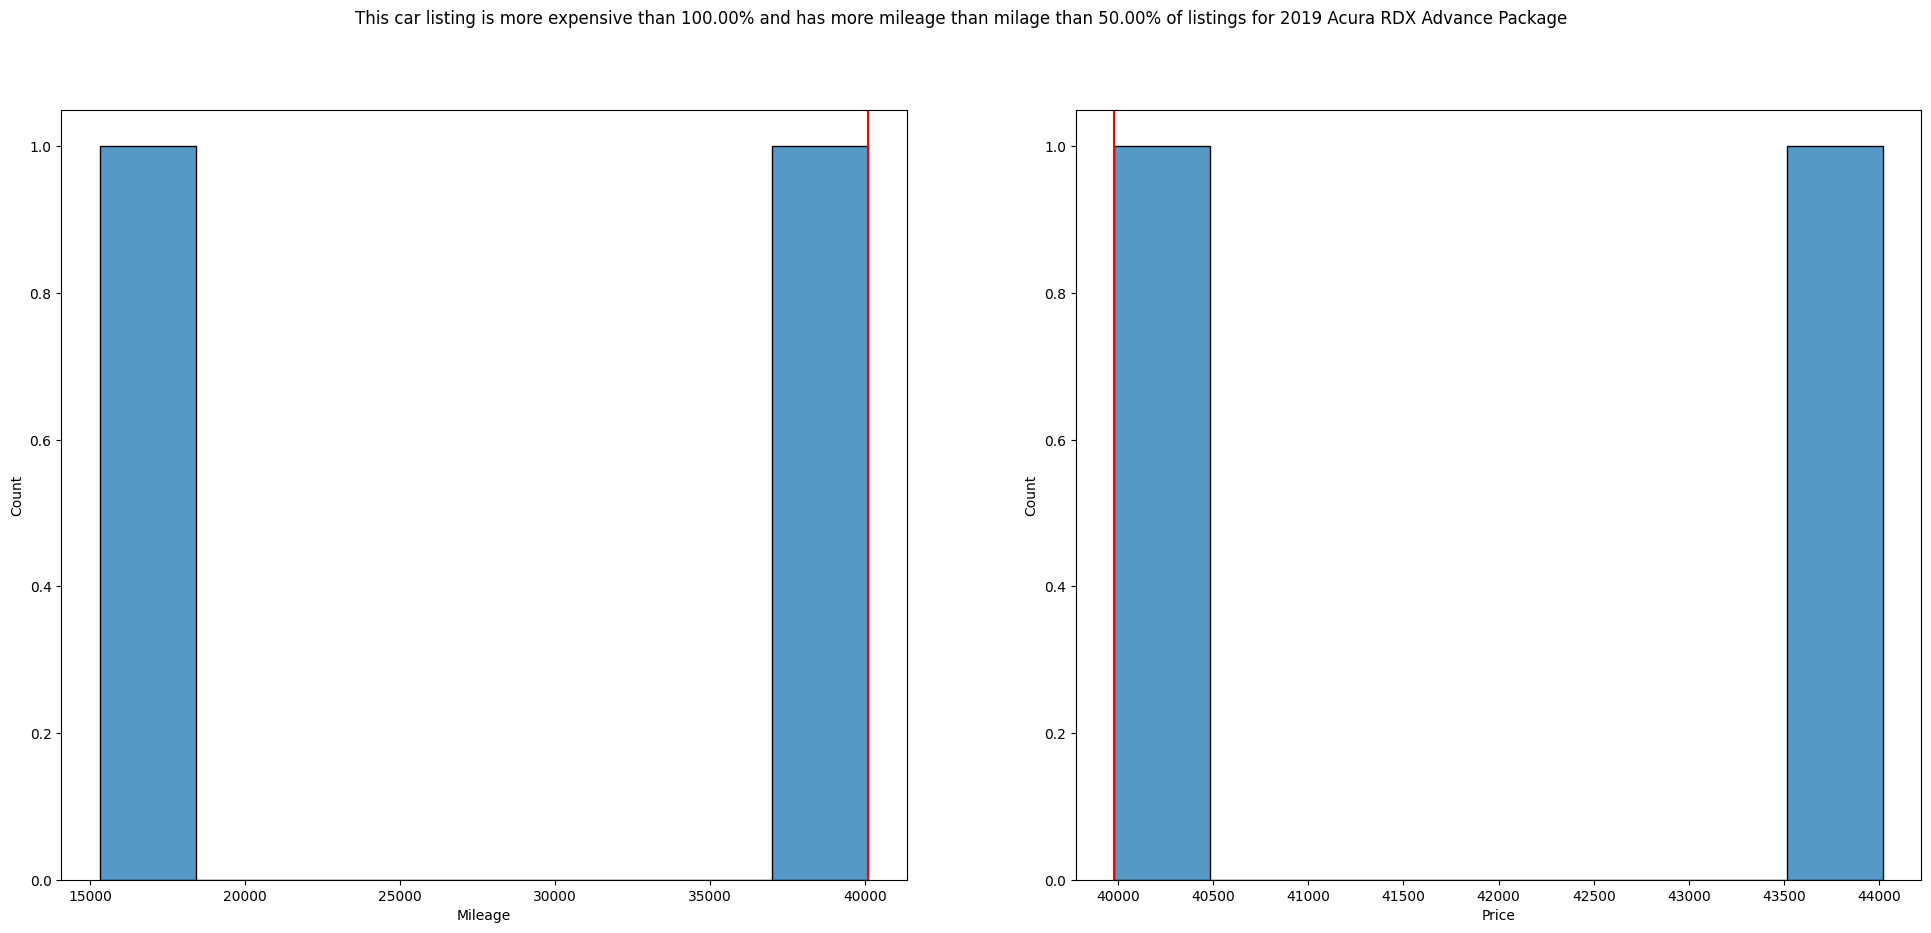

In [60]:
def hist_plot_with_listing(df_hist, row):

    record = df_hist.iloc[row]
    fig, ax = plt.subplots(1,2, figsize=(24,10))

    df_hist_filtered = df_hist[df_hist['Name'] == record['Name']]

    sns.histplot(
        data = df_hist_filtered['Mileage'],
        bins = 8,
        ax = ax[0]
    )


    sns.histplot(
        data = df_hist_filtered['Price'],
        bins = 8,
        ax = ax[1]
    )

    ax[0].axvline(record['Mileage'], color = 'red', linewidth = 1.5)
    ax[1].axvline(record['Price'], color = 'red', linewidth = 1.5)

    fig.suptitle(
        'This car listing is more expensive than {:.2f}% and has more mileage than milage than {:.2f}% of listings for {}' \
            .format(
                stats.percentileofscore(df_hist_filtered['Mileage'], record['Mileage'], kind = 'weak'), 
                stats.percentileofscore(df_hist_filtered['Price'], record['Price'], kind = 'weak'),
                record['Name'])
    )

    plt.show()

hist_plot_with_listing(df_last_week, 3)

##### A user can select one table item